<a href="https://colab.research.google.com/github/Pai-Ya-Ting/Text-mining/blob/main/Amazon-review-classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification with supervised learning

In [ ]:
#download data from google drive
import gdown
url = "https://drive.google.com/uc?id=1jbb0HQ9oTZkRNK055AvXD3ya8_ZLtN9o"
gdown.download(url, "Amazon_review.csv", quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1jbb0HQ9oTZkRNK055AvXD3ya8_ZLtN9o
To: /content/Amazon_review.csv
4.52MB [00:00, 24.0MB/s]


'Amazon_review.csv'

In [ ]:
#load dataset into pandas dataframe
import pandas as pd
amazon_reviewDF = pd.read_csv("Amazon_review.csv",delimiter=',',header = None)
amazon_reviewDF.columns=['text', 'label'] # name the column of dataframe 
# amazon_reviewDF

In [ ]:
# !pip install spacy-transformers
# !python -m spacy download en_core_web_sm

In [ ]:
import spacy
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [ ]:
def preprocess (text, pos= True, pos_select = ["VERB", "NOUN", "ADJ","ADV","PART"]):
  # nlp = spacy.load('en_core_web_trf', disable=['parser', 'ner'])
  doc = nlp(text)
  if pos == True: 
    text_preprocess= " ".join([token.text for token in doc if token.pos_ in pos_select])
  else: 
    text_preprocess= " ".join([token.text for token in doc])
  return text_preprocess

In [ ]:
def preprocess_lemma_pos (text,lemma= True, pos= True, pos_select = ["VERB", "NOUN", "ADJ","ADV","PART"]):
  # nlp = spacy.load('en_core_web_trf', disable=['parser', 'ner'])
  doc = nlp(text)
  if pos== False:
    text_preprocess= " ".join([token.lemma_ for token in doc])
  else:
    text_preprocess= " ".join([token.lemma_ for token in doc if token.pos_ in pos_select])
  return text_preprocess

In [ ]:
# from tqdm.notebook import tqdm 
# amazon_reviewDF_lem_pos = amazon_reviewDF.copy()
# amazon_reviewDF['text'] = amazon_reviewDF['text'].map(lambda x: preprocess(x))
# amazon_reviewDF_lem_pos['text'] = amazon_reviewDF_lem_pos['text'].map(lambda x: preprocess_lemma_pos(x))
# amazon_reviewDF_lem_pos.to_csv("Amazon_review_lem_pos.csv", index = False)

**Use 2 data to do classification:** the original one and the data after lemmatization, pos.

In [ ]:
import pandas as pd
amazon_reviewDF_lem_pos = pd.read_csv("Amazon_review_lem_pos.csv", delimiter=',')

**Split Training - Testing data for validation**

In [ ]:
from sklearn import model_selection
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer

def get_data(df, max_features = None):
  # split the dataset into training and testing 
  train_x, valid_x, train_y, valid_y = model_selection.train_test_split(df['text'], df['label'], test_size=0.1, random_state=1, stratify = df['label'])

  # encode the target variable, label Negative/Positive -> 0/1
  encoder = preprocessing.LabelEncoder()
  train_y_en = encoder.fit_transform(train_y)
  valid_y_en = encoder.fit_transform(valid_y)

  # word level tf-idf
  tfidf_vect = TfidfVectorizer(stop_words='english',  max_features = max_features)
  tfidf_vect.fit(train_x.values.astype('U')) #Learn vocabulary and idf from training data set. (in bad words)
  xtrain_tfidf =  tfidf_vect.transform(train_x.values.astype('U')) # compute tfidf for tranning data set
  xvalid_tfidf =  tfidf_vect.transform(valid_x.values.astype('U')) # compute tfidf for testing data set

  return xtrain_tfidf, train_y_en, xvalid_tfidf, valid_y_en

(a) Test 1: Does using lemmatization and POS selection give a better result? Run the classification tree model using two dataframes.

**Use decision tree classifier**

In [ ]:
import matplotlib.pyplot as plt
from sklearn import tree,  metrics

In [ ]:
def train_Tree(X_train, y_train, X_test, y_test):
  classifier_tree = tree.DecisionTreeClassifier(random_state=1)
  # fit the training dataset on the classifier
  classifier_tree = classifier_tree.fit(X_train, y_train)

  # predict the labels on validation dataset
  valid_y_pred_tree = classifier_tree.predict(X_test)
  accuracy_tree = metrics.accuracy_score(y_test, valid_y_pred_tree)
  confusion_matrix_tree = metrics.confusion_matrix(y_test, valid_y_pred_tree, labels=[0,1])
  F1_score1=metrics.f1_score(y_test, valid_y_pred_tree)

  print (f"Accuracy:{accuracy_tree}, F-score:{round(F1_score1, 3)}")
  print ("confusion_matrix\n", confusion_matrix_tree)

  metrics.plot_roc_curve(classifier_tree, X_test, y_test)
  plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
  plt.show()

Accuracy:0.716, F-score:0.72
confusion_matrix
 [[351 159]
 [125 365]]


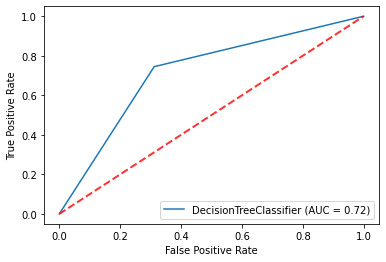

In [ ]:
X_train, y_train, X_test, y_test = get_data(amazon_reviewDF)
train_Tree(X_train, y_train, X_test, y_test)

Accuracy:0.681, F-score:0.686
confusion_matrix
 [[332 178]
 [141 349]]


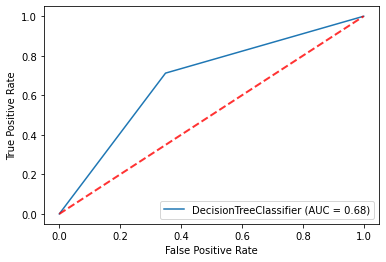

In [ ]:
X_train, y_train, X_test, y_test = get_data(amazon_reviewDF_lem_pos)
train_Tree(X_train, y_train, X_test, y_test)

(b) Test 2: if we limit the max_feature, does it affect the model performance?

Case 1: max_features = 5000

Accuracy:0.723, F-score:0.723
confusion_matrix
 [[362 148]
 [129 361]]


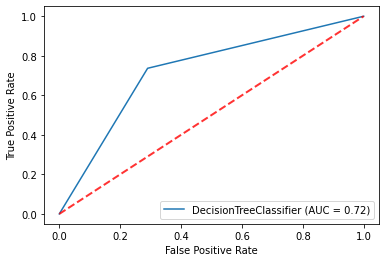

In [ ]:
X_train, y_train, X_test, y_test = get_data(amazon_reviewDF, 5000)
train_Tree(X_train, y_train, X_test, y_test)

Accuracy:0.707, F-score:0.711
confusion_matrix
 [[347 163]
 [130 360]]


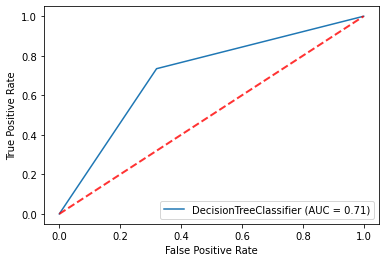

In [ ]:
X_train, y_train, X_test, y_test = get_data(amazon_reviewDF_lem_pos, 5000)
train_Tree(X_train, y_train, X_test, y_test)

Case 2: max_features = 7000

Accuracy:0.71, F-score:0.713
confusion_matrix
 [[350 160]
 [130 360]]


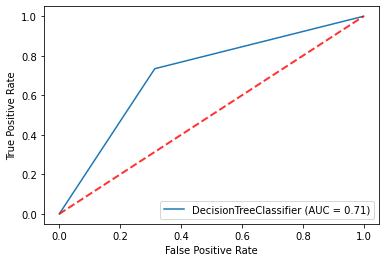

In [ ]:
X_train, y_train, X_test, y_test = get_data(amazon_reviewDF, 7000)
train_Tree(X_train, y_train, X_test, y_test)

Accuracy:0.682, F-score:0.686
confusion_matrix
 [[334 176]
 [142 348]]


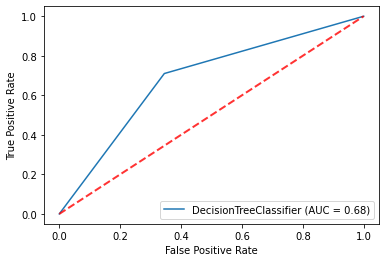

In [ ]:
X_train, y_train, X_test, y_test = get_data(amazon_reviewDF_lem_pos, 7000)
train_Tree(X_train, y_train, X_test, y_test)

Case 3: max_features = 9000

Accuracy:0.709, F-score:0.71
confusion_matrix
 [[353 157]
 [134 356]]


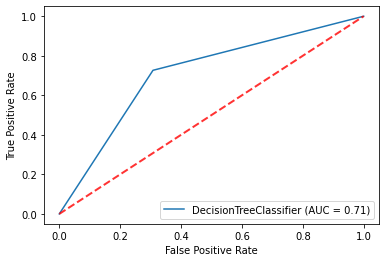

In [ ]:
X_train, y_train, X_test, y_test = get_data(amazon_reviewDF, 9000)
train_Tree(X_train, y_train, X_test, y_test)

Accuracy:0.689, F-score:0.689
confusion_matrix
 [[344 166]
 [145 345]]


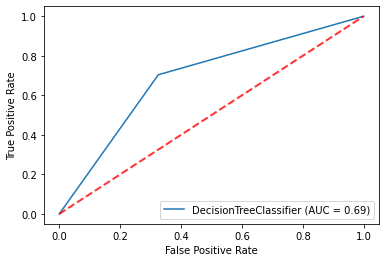

In [ ]:
X_train, y_train, X_test, y_test = get_data(amazon_reviewDF_lem_pos, 9000)
train_Tree(X_train, y_train, X_test, y_test)

(c) Text 3: Use different classification algorithm

**Use Neural Network- Multi-layer Perceptron classifier.**

In [ ]:
from sklearn.neural_network import MLPClassifier

def train_NN(X_train, y_train, X_test, y_test):
  classifier_nn = MLPClassifier(hidden_layer_sizes=(100,), random_state=1)
  classifier_nn.fit(X_train, y_train) # take around 3-4 minutes

  # predict the labels on validation dataset
  valid_y_pred_nn = classifier_nn.predict(X_test)

  accuracy_nn = metrics.accuracy_score(y_test, valid_y_pred_nn)
  confusion_matrix_nn = metrics.confusion_matrix(y_test, valid_y_pred_nn, labels=[0,1])
  F1_score=metrics.f1_score(y_test, valid_y_pred_nn)

  print (f"Accuracy:{accuracy_nn}, F-score:{round(F1_score, 3)}")
  print ("confusion_matrix\n", confusion_matrix_nn)

  metrics.plot_roc_curve(classifier_nn, X_test, y_test)
  plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
  plt.show()

Accuracy:0.819, F-score:0.816
confusion_matrix
 [[418  92]
 [ 89 401]]


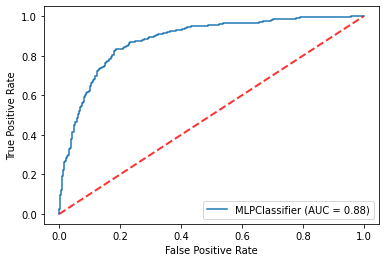

In [ ]:
X_train, y_train, X_test, y_test = get_data(amazon_reviewDF_lem_pos, 5000)
train_NN(X_train, y_train, X_test, y_test)

In [ ]:
from xgboost.sklearn import XGBClassifier

In [ ]:
def train_XGB(X_train, y_train, X_test, y_test):
  xgb_model = XGBClassifier(objective="binary:logistic", random_state=1)
  xgb_model.fit(X_train, y_train)

  y_pred = xgb_model.predict(X_test)
  accuracy_xgb = metrics.accuracy_score(y_test, y_pred)
  confusion_matrix = metrics.confusion_matrix(y_test, y_pred, labels=[0,1])
  F1_score=metrics.f1_score(y_test, y_pred)

  print (f"Accuracy:{accuracy_xgb}, F-score:{round(F1_score, 3)}")
  print ("confusion_matrix\n", confusion_matrix)

  metrics.plot_roc_curve(xgb_model, X_test, y_test)
  plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
  plt.show()

Accuracy:0.781, F-score:0.773
confusion_matrix
 [[409 101]
 [118 372]]


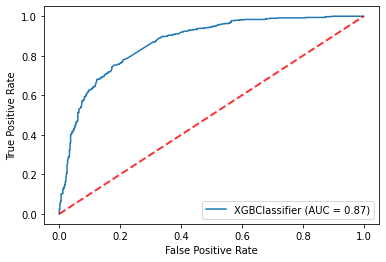

In [ ]:
train_XGB(X_train, y_train, X_test, y_test)